In [62]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [63]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage/",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


2022-03-28 15:06:31.152694: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-28 15:06:31.152914: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 15:06:31.153744: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print('Image batch shape: ', image_batch.shape)
    print('Label batch shape: ', label_batch.shape)

2022-03-28 15:08:06.989409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-28 15:08:07.001195: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Image batch shape:  (32, 256, 256, 3)
Label batch shape:  (32,)


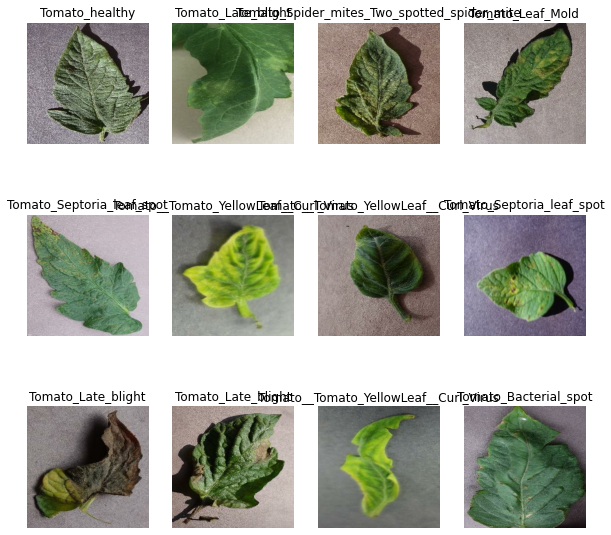

In [14]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [15]:
len(dataset)

501

80% ==> train
20% ==> 10% validation, 10% test

In [29]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size)
    train_ds = ds.skip(int(len(ds)*(1-train_split-val_split-test_split)))
    val_ds = train_ds.skip(int(len(train_ds)*(1-val_split-test_split)))
    test_ds = val_ds.skip(int(len(val_ds)*(1-test_split)))
    return train_ds, val_ds, test_ds

In [30]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [42]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Training

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (32, 30, 30, 64)         

In [50]:
wandb.init(project="plantvillage", entity="christhurber10", name="plantvillage",
           config={
               "learning_rate": 0.001,
               "epochs": EPOCH,
               "batch_size": BATCH_SIZE,
               "loss_function" : "SparseCategoricalCrossentropy",
               "architecture" : "CNN",
               "dataset" : "PlantVillage",
               "optimizer" : "Adam"
           })
config = wandb.config

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [66]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[WandbCallback()]
)

Epoch 1/50
501/501 [==============================] - 285s 569ms/step - loss: 0.7862 - accuracy: 0.7304 - val_loss: 0.4690 - val_accuracy: 0.8436
Epoch 2/50
501/501 [==============================] - 283s 566ms/step - loss: 0.4703 - accuracy: 0.8372 - val_loss: 0.3831 - val_accuracy: 0.8654
Epoch 3/50
501/501 [==============================] - 279s 556ms/step - loss: 0.3668 - accuracy: 0.8742 - val_loss: 0.4497 - val_accuracy: 0.8373
Epoch 4/50
501/501 [==============================] - 287s 573ms/step - loss: 0.2839 - accuracy: 0.9007 - val_loss: 0.2299 - val_accuracy: 0.9216
Epoch 5/50
501/501 [==============================] - 281s 561ms/step - loss: 0.2545 - accuracy: 0.9129 - val_loss: 0.2523 - val_accuracy: 0.9106
Epoch 6/50
501/501 [==============================] - 284s 566ms/step - loss: 0.2024 - accuracy: 0.9288 - val_loss: 0.1212 - val_accuracy: 0.9590
Epoch 7/50
501/501 [==============================] - 287s 572ms/step - loss: 0.1524 - accuracy: 0.9474 - val_loss: 0.1330 -

In [70]:
model_version=1
model.save(f"plantvillage_model_v{model_version}.h5")

ValueError: invalid literal for int() with base 10: 'plantvillage_model_v1.h5'